<a href="https://colab.research.google.com/github/nurikahraman/FoodTracker/blob/main/YOLO_NAS_ile_Google_Colab%E2%80%99de_Nesne_Tespiti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **YOLO-NAS ile Google Colab’de Nesne Tespiti**
**KANAK:**
https://medium.com/@ikranergiz0/yolo-nas-ile-google-colabde-nesne-tespiti-0a6b182cff25

Literatür taraması yaptığımda, son çıkan model olmasından kaynaklandığını düşünüyorum, hiç türkçe yazılı bir kaynağa rastlamadım. Bu sebeple araştırma sürecinde edindiğim bilgileri aktarmak ve son YOLO-NAS modelinin eğitimi hakkında bir doküman hazırlamak amacıyla bu yazıyı hazırladım.

Keyifli okumalar !

# **1.Kısım : YOLO-NAS Nedir?**
Deci AI tarafından Mayıs 2023'de yayınlanan YOLO-NAS, dünyanın en iyi doğruluk-gecikme (accuracy-latency) performansını sunan yeni bir nesne tespit mimarisidir. En son teknoloji (state-of-the-art) performansıyla gerçek zamanlı (real-time) nesne tespiti yapabilen model, Deci AI’ın geliştirdiği super-gradients paketiyle kullanıma sunulmuştur.

YOLO-NAS (You Only Look Once Neural Architecture Search), COCO veri seti üzerinde değerlendirildiğinde, YOLOv6 ve YOLOv8 gibi önceki sürümlere göre daha düşük gecikme (latency) ile daha yüksek mAP (mean average precision) değeri elde etmiştir. Deci AI’ın YOLO-NAS performans ölçümlerini içeren aşağıdaki grafik, YOLO-NAS’ın YOLOv5, YOLOv6, YOLOv7 ve YOLOv8 modellerini kesin bir şekilde geride bıraktığını göstermektedir.

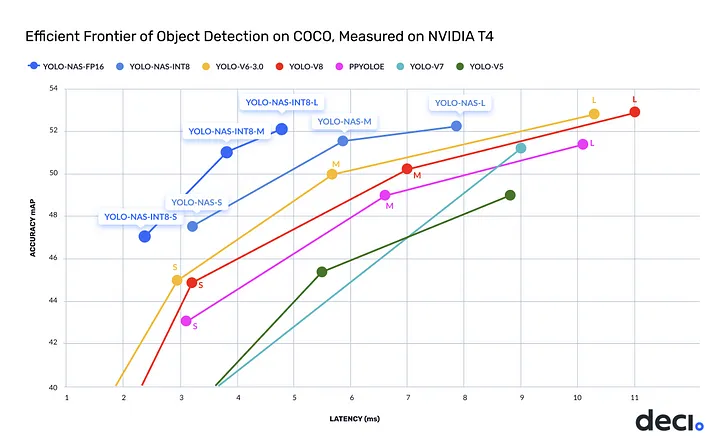

Yukarıdaki grafik, COCO veri seti üzerinde NVIDIA T4 kullanılarak ölçülen YOLO-NAS ve en iyi nesne tespit modellerinin performanslarını gösterir. [https://github.com/Deci-AI/super-gradients/blob/master/YOLONAS.md]

# **2. Kısım : Kendi Veri Setinizle YOLO-NAS’ı Eğitin.**
Yazının devamında, Google Colab üzerinde YOLO-NAS modelini kendi veri setiniz ile nasıl eğitileceğiniz üzerinde duracağım.

Süreçte kullanacağım veri seti 2100 eğitim, 300 validasyon ve 600 test olmak üzere 3000 süpernova görüntüsü içermekte ve etiket bilgileri .txt uzantılı dosyalarda yer almaktadır. YOLO formatına uygun, istediğiniz bir veri setiyle süreci devam ettirebilirsiniz.

Eğer hazırsak, YOLO-NAS ile eğitim sürecine başlayalım :)

# **Google Drive’a Bağlanma**
Veri seti Google Drive’da yer aldığı için öncelikle Drive’a bağlanıyoruz.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **YOLO-NAS Kurulumu**
Modelinin kurulumu için super-gradients paketini indiriyoruz. (Yazının yayınlandığı 16-/11/2023 itibarıyla paketin son sürümü 3.3.1'dir.)

In [1]:
!pip install super-gradients

**Uyarı!** Kurulumun ardından “Restart Runtime” diyerek Runtime’ı yeniden başlatmamız gerekiyor. YOLO-NAS’ın anlatıldığı “Intro to SuperGradients + YOLONAS Starter Notebook” unda ‘Installations’ kısmında bu durumdan ve hataları önlediğinden bahsedilmiş.

# **Kütüphaneleri Import Etme**
Eğitimi gerçekleştirmek için gerekli kütüphaneleri ekliyoruz.

In [2]:
from IPython.display import clear_output
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

[2024-05-03 21:20:35] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-05-03 21:20:45] INFO - utils.py - NumExpr defaulting to 2 threads.


# **Konfigürasyon**
Eğitim süreci için veri setiyle ilgili ayarlamamız gereken bazı parametreler var. Örneğin, veri setinin eğitim, test ve validasyon klasörlerinin yollarını tanımlamamız gerekiyor. Daha önceki YOLO modellerinde, .yaml uzantılı konfigürasyon dosyası ile bu süreç yürütülüyor. YOLO-NAS ise bunları tek tek parametre olarak alıyor. Bu parametreleri bir sınıf (class) altında topluyoruz ve veri setimize uygun değerler veriyoruz.

In [7]:
!echo ""
!echo "YOLO formatlı çıktı konumu ayarlandı."
!echo ""

!mkdir -p '/content/dataset/YOLO_Dataset/train/images'
!mkdir -p '/content/dataset/YOLO_Dataset/train/labels'
!mkdir -p '/content/dataset/YOLO_Dataset/val/images'
!mkdir -p '/content/dataset/YOLO_Dataset/val/labels'
!mkdir -p '/content/dataset/YOLO_Dataset/test/images'
!mkdir -p '/content/dataset/YOLO_Dataset/test/labels'
!mkdir -p '/content/dataset/checkpoint'

#input_path = "/content/dataset/COCO_Dataset/"
#output_path = "/content/dataset/YOLO_Dataset/"

#train_images = "/content/dataset/COCO_Dataset/train/images/"
#train_COCO_Dataset = "/content/dataset/COCO_Dataset/train/annotations.json"

#val_images = "/content/dataset/COCO_Dataset/val/images/"
#val_COCO_Dataset = "/content/dataset/COCO_Dataset/val/annotations.json"

#test_images = "/content/dataset/COCO_Dataset/test/images/"


YOLO formatlı çıktı konumu ayarlandı.



In [26]:
#@title Extract COCO Dataset
!echo "🗄 VALIDATION - Preparing dataset..."
#!unzip -q "/content/drive/MyDrive/Colab Notebooks/content/FoodRecognitionChallenge/val.zip" -d "/content/dataset/YOLO_Dataset/"

!echo "🗄 TRAINING - Preparing dataset..."
#!unzip -q "/content/drive/MyDrive/Colab Notebooks/content/FoodRecognitionChallenge/train.zip" -d "/content/dataset/YOLO_Dataset/"

!echo "🗄 TEST - Preparing dataset..."
#!unzip -q "/content/drive/MyDrive/Colab Notebooks/content/FoodRecognitionChallenge/test.zip" -d "/content/dataset/YOLO_Dataset/"

!echo "🗄 LABELS - Preparing labels..."
!unzip -q "/content/drive/MyDrive/Colab Notebooks/Aptal Buzdolabı/YOLO_Dataset.zip" -d "/content/dataset/"

🗄 VALIDATION - Preparing dataset...
🗄 TRAINING - Preparing dataset...
🗄 TEST - Preparing dataset...
🗄 LABELS - Preparing labels...


In [37]:
class config:
    #eğitim parametreleri
    CHECKPOINT_DIR = '/content/dataset/checkpoint/'# checkpoint klasörünün tam yolu (absolute path)
    EXPERIMENT_NAME = 'ilk_yolonas_calismasi' # eğitim sürecine verdiğimiz isim

    #veri seti parametreleri
    DATA_DIR = '/content/dataset/YOLO_Dataset/' # veri setinin bulunduğu ana klasör

    TRAIN_IMAGES_DIR = 'train/images' # DATA_DIR içinde eğitim verilerinin bulunduğu klasörün yolu
    TRAIN_LABELS_DIR = 'train/labels' # DATA_DIR içinde eğitim verilerinin etiketlerinin bulunduğu klasörün yolu

    VAL_IMAGES_DIR = 'val/images' # DATA_DIR içinde validasyon verilerinin bulunduğu klasörün yolu
    VAL_LABELS_DIR = 'val/labels' # DATA_DIR içinde validasyon verilerinin etiketlerinin  bulunduğu klasörün yolu

    TEST_IMAGES_DIR = 'test/images' # DATA_DIR içinde test verilerinin bulunduğu klasörün yolu
    TEST_LABELS_DIR = 'test/labels' # DATA_DIR içinde test verilerinin etiketlerinin  bulunduğu klasörün yolu
    CLASSES = [] # sınıfların isimleri.

    NUM_CLASSES = len(CLASSES)

    #ver-yükleyici (dataloader) parametreleri
    DATALOADER_PARAMS = {
      'batch_size':16,
      'num_workers':2
    }

    # model parametreleri
    MODEL_NAME = 'yolo_nas_l' # yolo_nas_s, yolo_nas_m, yolo_nas_l arasından birini seçiyoruz
    PRETRAINED_WEIGHTS = 'coco' # burada tek seçenek var: 'coco'

Eğitim sürecinde hata almamak için parametrelerin doğru ve uygun formatta olduğundan emin olmalıyız. Bunu gerçekleştirmek için aşağıda bahsedeceğim kısımları göz önünde bulundurabilirsiniz.

*   **EXPERIMENT_NAME** : YOLO-NAS, her eğitim sürecine bir isim atıyor. Bu isim EXPERIMENT_NAME kısmında string olarak tanımlanmalı. Örneğin, ilk-yolonas-calismam olabilir. Eğitimin ardından bu isimde bir klasör oluşturuyor ve bu klasörün altında best_weights.pt ya da latest-weights.pt gibi eğitim sonucu elde edilen dosyaları barındırıyor.
*   **CHECKPOINT_DIR** : Her eğitim sonunda oluşan klasörler bir ana klasörde toplanır. Böylece eğitimleri takip etmek kolaylaşır. Bu ana klasör checkpoint klasörüdür. Klasör adı konusunda bir kısıtlama olmamakla beraber istediğimiz bir yerde bu klasörü oluşturabiliriz. CHECKPOINT_DIR değişkenine bu ana klasörün tam yolunu (absolute path) veriyoruz.
*   **DATA_DIR** : Veri setimizin bulunduğu klasörün tam yolunu vereceğiz.
*   **TRAIN_IMAGES_DIR** : Veri setimizdeki eğitim görüntülerinin yolunu vereceğiz. Veri setinin yolunu DATA_DIR ayarladığımız için tam yolunu vermeyip eğitim klasörünün veri seti içerisindeki yolunu vereceğiz. Örneğin, train/images. Bu mantıkla TEST_IMAGES_DIR ve VAL_IMAGES_DIR oluşturabiliriz. Aynı adımları TEST_LABELS_DIR, TRAIN_LABELS_DIR ve VAL_LABELS_DIR için uygulayacağız.
*   **CLASSES** : Tespit etmek istediğimiz sınıfların isimlerini liste olarak veriyoruz. Süpernova örneği için sadece supernova yazacağız.
*   **DATALOADER_PARAMS** : batch_size ve num_workers tanımlıyoruz.
*   **MODEL_NAME** : yolo_nas_s, yolo_nas_m, yolo_nas_l arasından birini yazacağız.
*   **PRETRAINED_WEIGHTS** : Sadece coco yazılabiliyor.

Gerekli değişkenleri ayarladık. Eğitim sürecine başlayabiliriz.

# **Trainer**
İlk olarak, checkpoint klasörünün yolunu ve deney ismimizi vererek bir Trainer nesnesi oluşturuyoruz.

In [38]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

# **Veri Seti ve Dataloader**
Oluşturduğumuz veri seti parametrelerini kullanarak eğitim, validasyon ve test verilerini YOLO formatına çeviriyoruz ve eğitim, test ve validasyon veri setlerimizi oluşturuyoruz.

In [39]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

[2024-05-03 22:10:14] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 54392/54392 [00:10<00:00, 5081.10it/s]
[2024-05-03 22:10:25] WARNING - detection_dataset.py - Found 100256 invalid bbox that were ignored. For more information, please set `show_all_warnings=True`.


EmptyDatasetException: Empty Dataset: Out of 54392 images, not a single one was found with any of these classes: None

Veri setlerimiz veri artırma (data augmentation) ile farklı açılarda döndürülerek çoğaltılıyor. Eğitim verisinin veri artırmadan sonraki halini görmek için aşağıdaki kodu çalıştırabilirsiniz.

In [ ]:
train_data.dataset.plot()

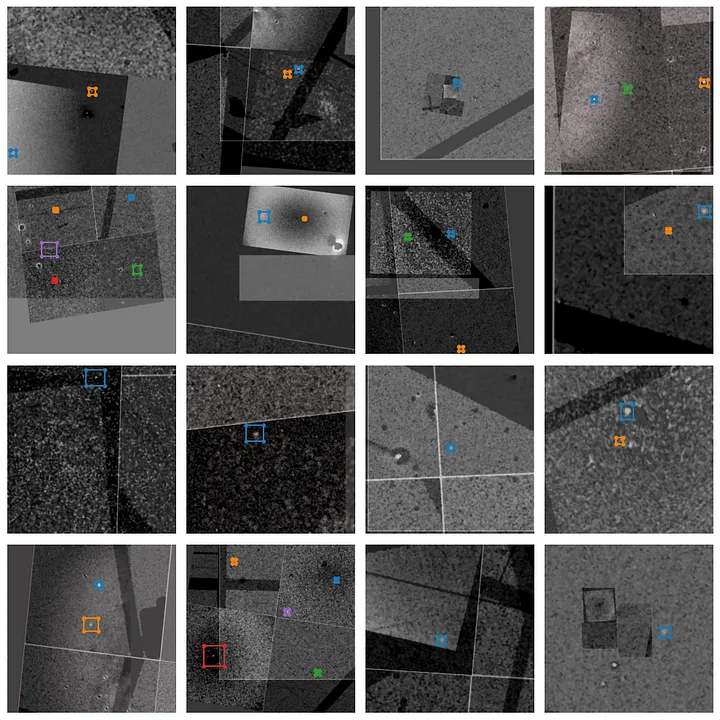

Veri artırma sonucu eğitim seti.

# **Modeli Oluşturma**
Veri setini ayarladıktan sonra YOLO-NAS modelimizi tam olarak oluşturabiliriz. num_classes argumanını eklemeyi unutmayın.

In [ ]:
model = models.get(config.MODEL_NAME,
                   num_classes=config.NUM_CLASSES,
                   pretrained_weights=config.PRETRAINED_WEIGHTS)

# **Metrikleri ve Eğitim Parametrelerini Ayarlama**
Eğitimden önce eğitim süreciyle ilgili tanımlamamızın zorunlu olduğu birkaç parametre var.

*   **max_epochs** : Maximum eğitim epoch sayısı.
*   **loss** : Kullanmak istediğimiz kayıp (loss) fonksiyonu.
*   **optimizer** : Kullanacağımız optimizer.
*   **train_metrics_list** : Eğitim sırasında izlenecek metrik.
*   **valid_metrics_list** : Validasyon sırasında izlenecek metrik.
*   **metric_to_watch** : Model checkpoint’inin kaydedileceği metrik.


In [ ]:
train_params = {
    "average_best_models":True,
    "warmup_mode": "LinearEpochLRWarmup",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},

    # BU ÖRNEK İÇİN 10 EPOCH EĞİTECEĞİZ
    "max_epochs": 10,
    "mixed_precision": False,

    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOT: num_classes burada tanımlanması gerekiyor
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),

    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes burada tanımlanması gerekiyor
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

# **Modeli Eğitme**
Tüm parametreleri ayarladığımıza göre artık modelimizi eğitebiliriz.

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

Kodu çalıştırdıktan sonra aşağıdaki gibi bir çıktı ile karşılaşacaksınız.

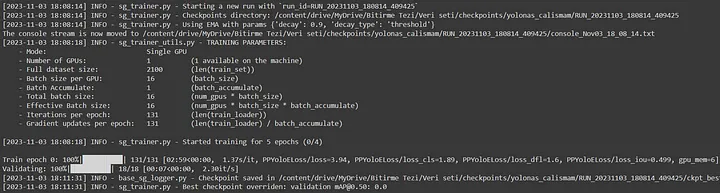

Model eğitiminin başladığını gösteren kod çıktısı.

Yukarıdaki çıktıda ilk olarak starting a new run satırını görüyoruz. Bu bir örnekle açıklamak gerekirse, yürüttüğümüz çalışmayı önce 10 epoch ile ardından 20 epoch ile yapmak istediğimizi varsayalım. Her eğitim sonucu bir dosya oluşacak ve bu dosyalar EXPERIMENT_NAME klasörünün altında yer alacak. Bu klasörlerin isimleri de tarihe dayalı olarak otomatik oluşuyor ve run_id ’ye atanıyor. Bunu, o an yaptığımız eğitimin ismi gibi düşünebiliriz. Önceki YOLO modellerinde runs klasöründe exp1, exp2 şeklinde bu dosyaları görüyorduk. Şimdi tarih bilgisine sahip isimleriyle eğitim çıktıları daha kolay takip edilebiliyor.

checkpoint klasörümüzün yolunu, eğitim parametrelerini (örn. batch_size) ve kaç epoch için eğitimin başlatıldığını görebiliyoruz.

Train epoch 0 eğitimin başladığını gösteriyor, ayrıca epoch’un ne kadar sürede tamamlandığı bilgisi de yer alıyor.

Herhangi bir epoch’un bitmesiyle aşağıda yer alan bir çıktı elde ediyoruz.

Eğitim ve validasyon adımlarındaki metrikler ve kayıp (loss) değerleri bir epoch’un ardından liste halinde sunuluyor. Daha önceki YOLO modellerinden farklı olarak bir önceki (N — 1) epoch’da hesaplanan verileri ve bu verilere göre N. epoch’daki değerlerin ne kadar değiştiğini ve bu değişimin artış mı yoksa azalış mı olduğunu, hem yeşil-kırmızı renkler hem de yukarı-aşağı oklarla görebiliyoruz. Verilerin bu yeni ve pratik sunuş şekli, veriler hakkında daha çok bilgi elde etmemize ve böylece daha hızlı gözlem yapabilmemize olanak sağlıyor.

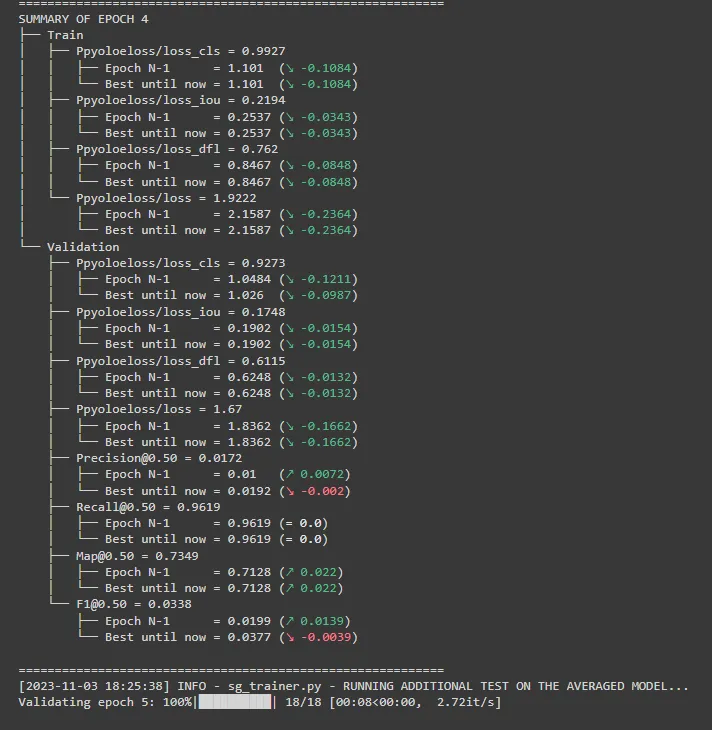

Bir epoch sonucu oluşan çıktı.

Eğitim ve validasyon adımlarındaki metrikler ve kayıp (loss) değerleri bir epoch’un ardından liste halinde sunuluyor. Daha önceki YOLO modellerinden farklı olarak bir önceki (N — 1) epoch’da hesaplanan verileri ve bu verilere göre N. epoch’daki değerlerin ne kadar değiştiğini ve bu değişimin artış mı yoksa azalış mı olduğunu, hem yeşil-kırmızı renkler hem de yukarı-aşağı oklarla görebiliyoruz. Verilerin bu yeni ve pratik sunuş şekli, veriler hakkında daha çok bilgi elde etmemize ve böylece daha hızlı gözlem yapabilmemize olanak sağlıyor.

# **En İyi Modeli Alma**
Eğitim tamamlanmasıyla eğitilmiş en iyi modeli (best model) kullanabiliriz. Bu modeli oluşturmak için eğitim sonucu oluşan en iyi ağırlıkları (ckpt_best.pth) kullanacağız.

In [ ]:
import os
checkpoint_path_best_model = os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth")

En iyi ağırlıklar yerine en son ağırlıkları (ckpt_latest.pth) kullanmak istiyorsanız aşağıdaki kodu kullanabilirsiniz.

In [ ]:
checkpoint_path_latest_model = os.path.join(trainer.checkpoints_dir_path, "ckpt_latest.pth")

Bu ağırlıklar ile eğitilmiş en iyi modelimizi oluşturuyoruz.

# **En İyi Modeli Test Etme**
Eğittiğimiz modeli test veri setimizle test ediyoruz.

In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=config.NUM_CLASSES,
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)))

Test işleminin ardından aşağıdaki gibi bir çıktı alacağız.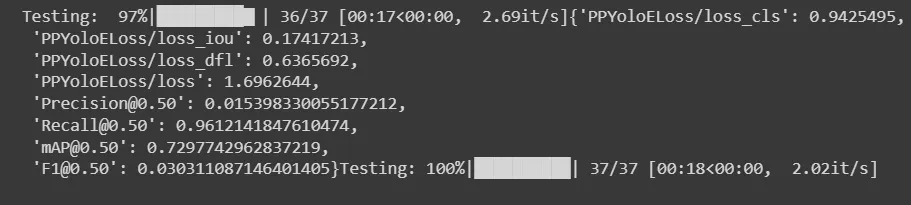

Test sonucu daha önce belirlediğimiz metriklerin değerlerini görebiliyoruz.

Süpernova örneğimizde 2100 görüntüyü 10 epoch eğittik ve 600 görüntü ile elde ettiğimiz mAP@0.50 skoru 0.72. 10 epoch eğittiğimiz model, rastgelelikten uzak ve tespit sürecini hızlandırabilecek bir sonuç ortaya çıkardı. Daha çok veri ve daha yüksek epoch sayısı ile elde edebileceğimiz modelleri bir hayal edelim!

# **En İyi Modelle Tahmin Üretme**
Model nesnesinin .predict() fonksiyonuyla istediğiniz bir resimde modeli çalıştırabilirsiniz.

Önemli! Eşik değerini conf ile ayarlamazsanız çıktınızda sınırlayıcı kutu (bounding box) göremeyebilirsiniz. Bu değeri istediğiniz gibi ayarlayabilirsiniz. 0.25 değerini atadığımızda bu değerden yüksek tahminlerini çıktı olarak gösterecektir.

In [ ]:
best_model.predict( "/content/drive/MyDrive/h0005_2.jpg",  conf=0.25).show()

Kodun çalışmasıyla aşağıdaki çıktıyı elde ediyoruz. Görüntüde birçok sınırlayıcı kutu (bounding box) olmasının sebebi, yer alan bir bug’dan kaynaklı. (*Issue link : https://github.com/Deci-AI/super-gradients/issues/1500*)

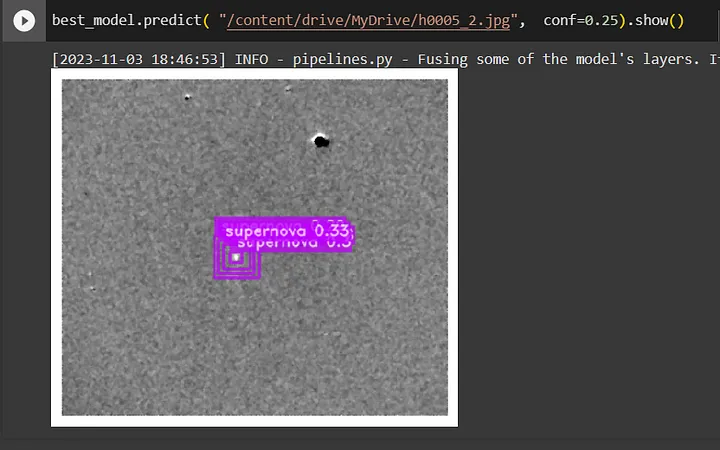

Eğitilmiş modelin bir girdi görüntüsünde ürettiği görüntü.

Sürecin sonunda 9 tane resimle modeli test ettim. Sonuçları Notebook’da bulabilirsiniz.

Artık süpernova tespit etmek için görüntüdeki tüm noktaları tek tek incelemek yerine, yüksek potansiyele sahip noktalara bakarak süpernova tespit işlemimizi saniyeler içerisinde gerçekleştirebileceğiz!

# **Sonuç**
YOLO modellerinin son versiyonu olan YOLO-NAS’ı Colab kullanarak nasıl eğiteceğimizden bahsettik. Temel adımları kendi veri setinize ve ihtiyacınıza göre düzenleyerek eğitimlerinizi gerçekleştirebilirsiniz.

Bu blog yazısı, TÜBİTAK 2209-A Üniversite Öğrencileri Araştırma Projesi Destekleme Programı (Proje Numarası: 1919B012220094) kapsamında gerçekleştirilen proje çalışması sürecinde hazırlanmıştır. Bu çalışma ISAR (Image and Signal Analysis Research) Lab tarafından yürütülmüştür. TÜBİTAK BİDEP Programı ve ISAR Lab tarafından sağlanan destek için teşekkürlerimi sunarım.

*Yazıda bahsettiğim kodlara Google Colab Notebook’umdan ya da GitHub hesabımdan ulaşabilirsiniz.*

Yorumlar aracılığıyla düşüncelerinizi ve geri dönüşlerinizi iletebilirsiniz.

**Ikra Nergiz**